In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.saving import register_keras_serializable
from keras import layers, Model, losses
from keras_facenet import FaceNet
import pandas as pd
import numpy as np
import os
from pathlib import Path
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/

In [3]:
DATASET_PATH = "C:/Users/DELL/Downloads/datasets/UTKface_inthewild/part1"

In [4]:
CONFIG = {
    'batch_size': 32,
    'img_size': 160,
    'epochs': 20,
    'sample_size': None,  
    'finetune_lr': 0.0001,
    'validation_split': 0.2,
    'random_seed': 42
}

In [25]:
class UTKFaceDataProcessor:
    def __init__(self, img_dir, img_size=160, sample_size=None, is_validation=False):
        self.img_size = img_size
        self.img_dir = img_dir
        self.is_validation = is_validation
        
        # Parse UTKFace filenames to extract labels
        self.parse_utkface_filenames()
        
        # Filter dataset to keep only valid entries
        original_len = len(self.df)
        self.df = self.df[(self.df['age'] >= 0) & (self.df['age'] <= 116)].reset_index(drop=True)
        print(f"Removed {original_len - len(self.df)} rows with invalid ages")
        
        # Sample data if specified
        if sample_size and sample_size < len(self.df):
            self.df = self.df.sample(n=sample_size, random_state=42).reset_index(drop=True)
            print(f"Sampled {'validation' if is_validation else 'training'}: {len(self.df)} samples")
        
        # Create age bins for classification
        self.create_age_bins()
    
    def setup_encoders(self, age_encoder=None, gender_encoder=None, race_encoder=None):
        """Initialize and fit label encoders"""
        
        if age_encoder is None:
            age_bins = ['0-2','3-9','10-19','20-29','30-39','40-49','50-59','60-69','70+']
            self.age_encoder = LabelEncoder()
            self.age_encoder.fit(age_bins)
        else:
            self.age_encoder = age_encoder
            
        if gender_encoder is None:
            self.gender_encoder = LabelEncoder()
            self.gender_encoder.fit(self.df['gender'].unique())
        else:
            self.gender_encoder = gender_encoder
            
        if race_encoder is None:
            self.race_encoder = LabelEncoder()
            self.race_encoder.fit(self.df['race'].unique())
        else:
            self.race_encoder = race_encoder
        
        # Encode labels
        self.df['age_encoded'] = self.age_encoder.transform(self.df['age_bin'])
        self.df['gender_encoded'] = self.gender_encoder.transform(self.df['gender'])
        self.df['race_encoded'] = self.race_encoder.transform(self.df['race'])
        
        self.num_classes = {
            'age': len(self.age_encoder.classes_),
            'gender': len(self.gender_encoder.classes_),
            'race': len(self.race_encoder.classes_)
        }
        
        if not self.is_validation:
            print(f"Classes - Age: {self.num_classes['age']}, Gender: {self.num_classes['gender']}, Race: {self.num_classes['race']}")
            print(f"Age bins: {list(self.age_encoder.classes_)}")
            print(f"Gender groups: {list(self.gender_encoder.classes_)}")
            print(f"Race groups: {list(self.race_encoder.classes_)}")

    def parse_utkface_filenames(self):
        """Parse UTKFace filenames to extract age, gender, race labels"""
        data = []
        
        for filename in os.listdir(self.img_dir):
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                parts = filename.split('_')
                if len(parts) >= 3:
                    try:
                        age = int(parts[0])
                        gender_code = parts[1]  # 0: female, 1: male
                        race_code = parts[2]    # 0: White, 1: Black, 2: Asian, 3: Indian, 4: Others
                        
                        # Map gender codes to labels
                        gender_mapping = {'0': 'Female', '1': 'Male'}
                        gender_label = gender_mapping.get(gender_code, 'Unknown')
                        
                        # Map race codes to labels
                        race_mapping = {
                            '0': 'White', 
                            '1': 'Black', 
                            '2': 'East Asian', 
                            '3': 'Indian', 
                            '4': 'Others'
                        }
                        race_label = race_mapping.get(race_code, 'Unknown')
                        
                        # Skip unknown labels
                        if gender_label != 'Unknown' and race_label != 'Unknown':
                            data.append({
                                'file': filename,
                                'age': age,
                                'gender': gender_label,
                                'race': race_label
                            })
                    except (ValueError, IndexError):
                        continue
        
        self.df = pd.DataFrame(data)
        if not self.is_validation:
            print(f"Loaded {len(self.df)} valid images from UTKFace dataset")
            print(f"Age distribution: min={self.df['age'].min()}, max={self.df['age'].max()}, mean={self.df['age'].mean():.1f}")
            print(f"Gender distribution:\n{self.df['gender'].value_counts()}")
            print(f"Race distribution:\n{self.df['race'].value_counts()}")

    def create_age_bins(self):
        """Create age bins for classification"""
        def age_to_bin(age):
            if age <= 2:
                return '0-2'
            elif age <= 9:
                return '3-9'
            elif age <= 19:
                return '10-19'
            elif age <= 29:
                return '20-29'
            elif age <= 39:
                return '30-39'
            elif age <= 49:
                return '40-49'
            elif age <= 59:
                return '50-59'
            elif age <= 69:
                return '60-69'
            else:
                return '70+'
        
        self.df['age_bin'] = self.df['age'].apply(age_to_bin)
        if not self.is_validation:
            print(f"Age bin distribution:\n{self.df['age_bin'].value_counts().sort_index()}")

    def load_and_preprocess_image(self, image_path, augment=False):
        """Load and preprocess single image"""
        try:
            image = tf.io.read_file(image_path)
            image = tf.image.decode_image(image, channels=3, expand_animations=False)
            image = tf.cast(image, tf.float32)
            image = tf.image.resize(image, [self.img_size, self.img_size])
            image = image / 255.0
            
            if augment:
                image = tf.image.random_flip_left_right(image)
                image = tf.image.random_brightness(image, 0.1)
                image = tf.image.random_contrast(image, 0.9, 1.1)
                # Remove saturation and hue for stability
            
            # Standardization
            image = tf.image.per_image_standardization(image)
            return image
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return a black image instead of zeros to maintain shape
            return tf.zeros([self.img_size, self.img_size, 3], dtype=tf.float32)

    def create_dataset(self, batch_size=32, augment=False, shuffle=True):
        """Create TensorFlow dataset - FIXED VERSION"""
        
        # Prepare data arrays
        image_paths = []
        age_labels = []
        gender_labels = []
        race_labels = []
        
        for idx, row in self.df.iterrows():
            img_path = os.path.join(self.img_dir, row['file'])
            if os.path.exists(img_path):  # Only include existing files
                image_paths.append(img_path)
                age_labels.append(row['age_encoded'])
                gender_labels.append(row['gender_encoded'])
                race_labels.append(row['race_encoded'])
        
        print(f"Creating dataset with {len(image_paths)} valid images")
        
        if len(image_paths) == 0:
            raise ValueError("No valid images found in dataset!")
        
        # Convert to tensors
        image_paths = tf.constant(image_paths)
        age_labels = tf.constant(age_labels, dtype=tf.int32)
        gender_labels = tf.constant(gender_labels, dtype=tf.int32)
        race_labels = tf.constant(race_labels, dtype=tf.int32)
        
        # Create dataset from tensors
        dataset = tf.data.Dataset.from_tensor_slices({
            'image_path': image_paths,
            'age': age_labels,
            'gender': gender_labels,
            'race': race_labels
        })
        
        # Define preprocessing function
        def preprocess_fn(data):
            image = self.load_and_preprocess_image(data['image_path'], augment)
            labels = {
                'age_head': data['age'],
                'gender_head': data['gender'],
                'race_head': data['race']
            }
            return image, labels
        
        # Apply preprocessing
        dataset = dataset.map(preprocess_fn, num_parallel_calls=tf.data.AUTOTUNE)
        
        if shuffle:
            dataset = dataset.shuffle(buffer_size=min(1000, len(image_paths)))
        
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        
        return dataset

In [29]:
# 222
@tf.keras.utils.register_keras_serializable()
class FaceNetMultiTask(tf.keras.Model):
    def __init__(self, num_age_classes, num_gender_classes, num_race_classes, freeze_backbone=False, **kwargs):
        super(FaceNetMultiTask, self).__init__(**kwargs)
        
        self.num_age_classes = num_age_classes
        self.num_gender_classes = num_gender_classes
        self.num_race_classes = num_race_classes
        self.freeze_backbone = freeze_backbone
        
        # Initialize FaceNet backbone
        self.backbone = FaceNet().model
        if freeze_backbone:
            self.backbone.trainable = False

        # Shared dense layer
        self.shared_dense = layers.Dense(512, activation='relu', name='shared_dense')
        self.shared_dropout = layers.Dropout(0.7, name='shared_dropout')

        # Task-specific classification heads
        self.age_dense = layers.Dense(128, activation='relu', name='age_dense')
        self.age_output = layers.Dense(num_age_classes, activation='softmax', name='age_output')
        
        self.gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')
        
        self.race_output = layers.Dense(num_race_classes, activation='softmax', name='race_output')

    def call(self, inputs, training=None):
        # Get FaceNet embeddings
        embeddings = self.backbone(inputs, training=training)
        
        # Shared processing
        shared_features = self.shared_dense(embeddings, training=training)
        shared_features = self.shared_dropout(shared_features, training=training)
        
        # Task-specific predictions
        age_features = self.age_dense(shared_features, training=training)
        age_pred = self.age_output(age_features, training=training)
        
        gender_pred = self.gender_output(shared_features, training=training)
        race_pred = self.race_output(shared_features, training=training)

        return {
            'age_output': age_pred,
            'gender_output': gender_pred,
            'race_output': race_pred
        }
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'num_age_classes': self.num_age_classes,
            'num_gender_classes': self.num_gender_classes,
            'num_race_classes': self.num_race_classes,
            'freeze_backbone': self.freeze_backbone
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [7]:
def create_and_compile_model(num_age_classes, num_gender_classes, num_race_classes, 
                           learning_rate=0.001, freeze_backbone=False):
    """Create and compile the multi-task model"""
    model = FaceNetMultiTask(
        num_age_classes=num_age_classes,
        num_gender_classes=num_gender_classes,
        num_race_classes=num_race_classes,
        freeze_backbone=freeze_backbone
    )

    # Build the model with sample input
    sample_input = tf.zeros((1, 160, 160, 3))
    _ = model(sample_input)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss={
            'age_output': losses.SparseCategoricalCrossentropy(),
            'gender_output': tf.keras.losses.BinaryCrossentropy(),
            'race_output': losses.SparseCategoricalCrossentropy()
        },
        loss_weights={
            'age_output': 1.0,
            'gender_output': 1.0,
            'race_output': 1.0
        },
        metrics={
            'age_output': ['sparse_categorical_accuracy'],
            'gender_output': ['binary_accuracy'],
            'race_output': ['sparse_categorical_accuracy']
        }
    )

    print(f"Model compiled successfully!")
    print(f"   - Backbone frozen: {freeze_backbone}")
    print(f"   - Learning rate: {learning_rate}")
    return model

In [8]:
print("Creating main data processor...")
main_processor = UTKFaceDataProcessor(
    DATASET_PATH,
    img_size=CONFIG['img_size'],
    sample_size=CONFIG['sample_size'],
    is_validation=False
)

# Setup encoders on main processor
main_processor.setup_encoders()

# Filter for valid age bins
valid_bins = main_processor.df['age_bin'].value_counts()
valid_bins = valid_bins[valid_bins > 1].index
filtered_df = main_processor.df[main_processor.df['age_bin'].isin(valid_bins)]

print(f"Filtered dataset: {len(filtered_df)} samples with valid age bins")

# Stratified split
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(
    filtered_df,
    test_size=0.2,
    random_state=42,
    stratify=filtered_df['age_bin']
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Create separate processors with the split data
train_processor = UTKFaceDataProcessor(DATASET_PATH, CONFIG['img_size'], is_validation=False)
train_processor.df = train_df.reset_index(drop=True)
train_processor.setup_encoders()

val_processor = UTKFaceDataProcessor(DATASET_PATH, CONFIG['img_size'], is_validation=True)
val_processor.df = val_df.reset_index(drop=True)
val_processor.setup_encoders()


Creating main data processor...
Loaded 20852 valid images from UTKFace dataset
Age distribution: min=1, max=116, mean=31.9
Gender distribution:
gender
Male      10525
Female    10327
Name: count, dtype: int64
Race distribution:
race
White         9314
Black         4298
East Asian    3513
Indian        2053
Others        1674
Name: count, dtype: int64
Removed 0 rows with invalid ages
Age bin distribution:
age_bin
0-2      1812
10-19    1502
20-29    6233
3-9      1501
30-39    3913
40-49    1820
50-59    1783
60-69    1116
70+      1172
Name: count, dtype: int64
Classes - Age: 9, Gender: 2, Race: 5
Age bins: [np.str_('0-2'), np.str_('10-19'), np.str_('20-29'), np.str_('3-9'), np.str_('30-39'), np.str_('40-49'), np.str_('50-59'), np.str_('60-69'), np.str_('70+')]
Gender groups: ['Female', 'Male']
Race groups: ['Black', 'East Asian', 'Indian', 'Others', 'White']
Filtered dataset: 20852 samples with valid age bins
Training samples: 16681
Validation samples: 4171
Loaded 20852 valid images 

In [9]:
print("\nCreating TensorFlow datasets...")
train_dataset = train_processor.create_dataset(
    batch_size=CONFIG['batch_size'],
    augment=True,
    shuffle=True
)

val_dataset = val_processor.create_dataset(
    batch_size=CONFIG['batch_size'],
    augment=False,
    shuffle=False
)



Creating TensorFlow datasets...
Creating dataset with 16681 valid images
Creating dataset with 4171 valid images


In [ ]:
print("\n" + "="*60)
print("Building Multi-Task FaceNet Model")
print("="*60)

# Create model
model = create_and_compile_model(
    num_age_classes=train_processor.num_classes['age'],
    num_gender_classes=train_processor.num_classes['gender'],
    num_race_classes=train_processor.num_classes['race'],
    learning_rate=0.001,
    freeze_backbone=True
)

# Display model summary
print("\nModel Architecture Summary:")
model.summary()

In [11]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_utkface_model.keras',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.CSVLogger('utk_ttraining_log.csv', append=False)
]


In [ ]:
# print("\n" + "="*60)
# print("Training")
# print("="*60)

# history = model.fit(
#     train_dataset,
#     epochs=20,
#     validation_data=val_dataset,
#     callbacks=callbacks,
#     verbose=1
# )

In [ ]:
model.summary()

In [ ]:
print("Available history keys:", list(history.history.keys()))

In [ ]:
def plot_training_history(history):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Total Loss
    ax1.plot(history.history['loss'], label='Training Loss', color='blue')
    ax1.plot(history.history['val_loss'], label='Validation Loss', color='red')
    ax1.set_title('Total Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Individual Task Losses
    ax2.plot(history.history['age_output_loss'], label='Age Train', color='red', linestyle='-')
    ax2.plot(history.history['val_age_output_loss'], label='Age Val', color='red', linestyle='--')
    ax2.plot(history.history['gender_output_loss'], label='Gender Train', color='green', linestyle='-')
    ax2.plot(history.history['val_gender_output_loss'], label='Gender Val', color='green', linestyle='--')
    ax2.plot(history.history['race_output_loss'], label='Race Train', color='orange', linestyle='-')
    ax2.plot(history.history['val_race_output_loss'], label='Race Val', color='orange', linestyle='--')
    ax2.set_title('Individual Task Losses')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    # Task Accuracies
    ax3.plot(history.history['age_output_sparse_categorical_accuracy'], label='Age Train', color='red', linestyle='-')
    ax3.plot(history.history['val_age_output_sparse_categorical_accuracy'], label='Age Val', color='red', linestyle='--')
    ax3.plot(history.history['gender_output_binary_accuracy'], label='Gender Train', color='green', linestyle='-')
    ax3.plot(history.history['val_gender_output_binary_accuracy'], label='Gender Val', color='green', linestyle='--')
    ax3.plot(history.history['race_output_sparse_categorical_accuracy'], label='Race Train', color='orange', linestyle='-')
    ax3.plot(history.history['val_race_output_sparse_categorical_accuracy'], label='Race Val', color='orange', linestyle='--')
    ax3.set_title('Task Accuracies')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy')
    ax3.legend()
    ax3.grid(True)

    # Learning Rate
    ax4.plot(history.history.get('learning_rate', []), label='Learning Rate', color='purple')
    ax4.set_title('Learning Rate Schedule')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Learning Rate')
    ax4.legend()
    ax4.grid(True)
    ax4.set_yscale('log')

    plt.tight_layout()
    plt.show()

    # Print final metrics
    print("\nFinal Training Metrics:")
    print(f"Total Loss: {history.history['loss'][-1]:.4f} | Val Loss: {history.history['val_loss'][-1]:.4f}")
    print(f"Age Accuracy: {history.history['age_output_sparse_categorical_accuracy'][-1]:.4f} | Val: {history.history['val_age_output_sparse_categorical_accuracy'][-1]:.4f}")
    print(f"Gender Accuracy: {history.history['gender_output_binary_accuracy'][-1]:.4f} | Val: {history.history['val_gender_output_binary_accuracy'][-1]:.4f}")
    print(f"Race Accuracy: {history.history['race_output_sparse_categorical_accuracy'][-1]:.4f} | Val: {history.history['val_race_output_sparse_categorical_accuracy'][-1]:.4f}")

plot_training_history(history)

Evaluating model performance...

Final Validation Accuracies:
  Age: 0.0892
  Gender: 0.4944
  Race: 0.2040
  Average: 0.2625


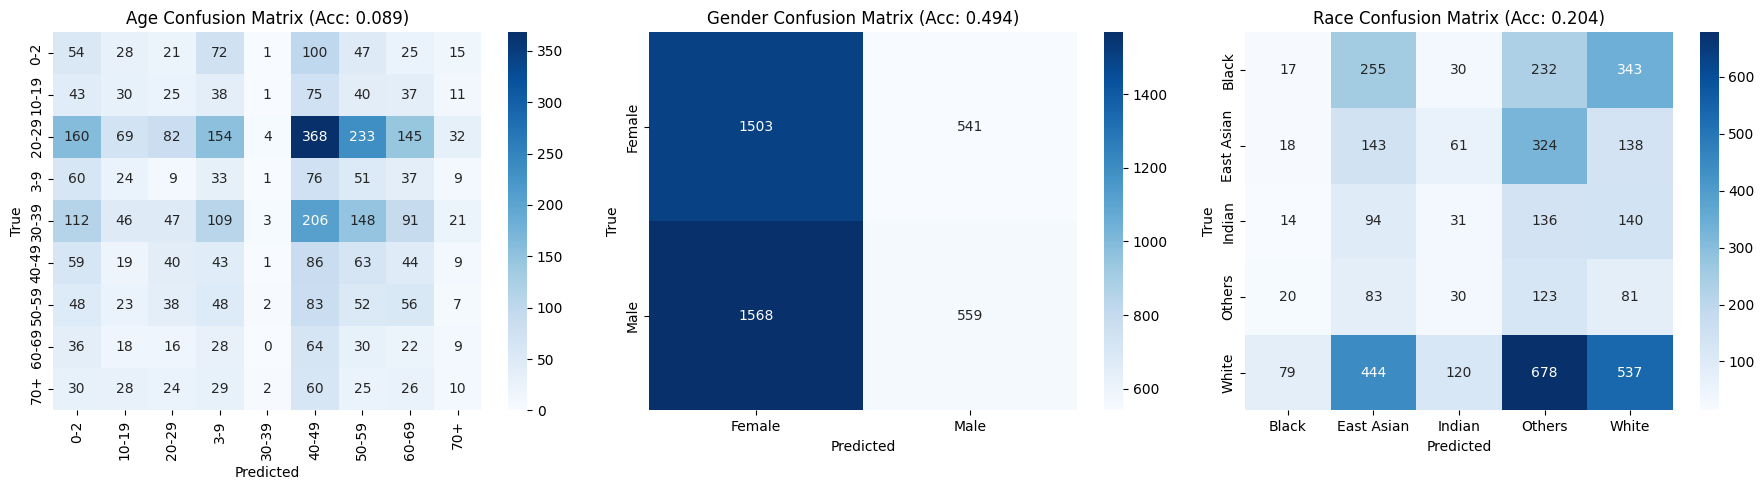

In [ ]:
def evaluate_model_performance(model, val_dataset, val_processor):
    """Evaluate model performance and create confusion matrices"""
    print("Evaluating model performance...")
    
    # Get predictions
    y_true_age, y_true_gender, y_true_race = [], [], []
    y_pred_age, y_pred_gender, y_pred_race = [], [], []
    
    for batch_x, batch_y in val_dataset:
        preds = model.predict(batch_x, verbose=0)
        
        y_true_age.extend(batch_y['age_output'].numpy())
        y_true_gender.extend(batch_y['gender_output'].numpy())
        y_true_race.extend(batch_y['race_output'].numpy())
        
        y_pred_age.extend(np.argmax(preds['age_output'], axis=1))
        y_pred_gender.extend(np.argmax(preds['gender_output'], axis=1))
        y_pred_race.extend(np.argmax(preds['race_output'], axis=1))
    
    # Calculate accuracies
    age_acc = accuracy_score(y_true_age, y_pred_age)
    gender_acc = accuracy_score(y_true_gender, y_pred_gender)
    race_acc = accuracy_score(y_true_race, y_pred_race)
    
    print(f"\nFinal Validation Accuracies:")
    print(f"  Age: {age_acc:.4f}")
    print(f"  Gender: {gender_acc:.4f}")
    print(f"  Race: {race_acc:.4f}")
    print(f"  Average: {(age_acc + gender_acc + race_acc)/3:.4f}")
    
    # Plot confusion matrices
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Age confusion matrix
    age_cm = confusion_matrix(y_true_age, y_pred_age)
    sns.heatmap(age_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=val_processor.age_encoder.classes_,
                yticklabels=val_processor.age_encoder.classes_)
    axes[0].set_title(f'Age Confusion Matrix (Acc: {age_acc:.3f})')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    
    # Gender confusion matrix
    gender_cm = confusion_matrix(y_true_gender, y_pred_gender)
    sns.heatmap(gender_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
                xticklabels=val_processor.gender_encoder.classes_,
                yticklabels=val_processor.gender_encoder.classes_)
    axes[1].set_title(f'Gender Confusion Matrix (Acc: {gender_acc:.3f})')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    
    # Race confusion matrix
    race_cm = confusion_matrix(y_true_race, y_pred_race)
    sns.heatmap(race_cm, annot=True, fmt='d', cmap='Blues', ax=axes[2],
                xticklabels=val_processor.race_encoder.classes_,
                yticklabels=val_processor.race_encoder.classes_)
    axes[2].set_title(f'Race Confusion Matrix (Acc: {race_acc:.3f})')
    axes[2].set_xlabel('Predicted')
    axes[2].set_ylabel('True')
    
    plt.tight_layout()
    plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return {
        'age_accuracy': age_acc,
        'gender_accuracy': gender_acc,
        'race_accuracy': race_acc,
        'average_accuracy': (age_acc + gender_acc + race_acc) / 3
    }

# Evaluate the model
evaluation_results = evaluate_model_performance(model, val_dataset, val_processor)

In [ ]:
def save_model_and_encoders(model, train_processor, model_name="utkface_multitask_model"):
    """Save trained model and label encoders in .keras format"""
    
    # Save the complete model in .keras format
    model_path = f"{model_name}.keras"
    model.save(model_path)
    print(f"Model saved as {model_path}")
    
    # Save label encoders and metadata
    encoders_data = {
        'age_encoder': train_processor.age_encoder,
        'gender_encoder': train_processor.gender_encoder,
        'race_encoder': train_processor.race_encoder,
        'num_classes': train_processor.num_classes,
        'age_classes': list(train_processor.age_encoder.classes_),
        'gender_classes': list(train_processor.gender_encoder.classes_),
        'race_classes': list(train_processor.race_encoder.classes_),
        'config': CONFIG
    }
    
    encoders_path = f"{model_name}_encoders.pkl"
    with open(encoders_path, 'wb') as f:
        pickle.dump(encoders_data, f)
    print(f"Encoders and metadata saved as {encoders_path}")
    
    # Save model weights separately as backup
    weights_path = f"{model_name}_weights.h5"
    model.save_weights(weights_path)
    print(f"Model weights saved as {weights_path}")
    
    return model_path, encoders_path, weights_path

print("\n" + "="*60)
print("SAVING TRAINED MODEL")
print("="*60)

# Save the final model
model_path, encoders_path, weights_path = save_model_and_encoders(model, train_processor)


In [ ]:
import lime
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import quickshift
import shap
from PIL import Image

In [ ]:
MODEL_PATH = "utkface_model.keras"
ENCODERS_PATH = "label_encoders.pkl"
IMAGES_PATH = "C:/Users/DELL/Downloads/datasets/UTKface_inthewild/part1"  

In [30]:
# Load the trained model
print("Loading model...")
try:
    model = tf.keras.models.load_model(MODEL_PATH, custom_objects={'FaceNetMultiTask': FaceNetMultiTask},
            safe_mode=False, compile=False)
    print(f"Model loaded successfully from {MODEL_PATH}")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please ensure the model file exists and was saved correctly during training.")
    raise

# Load label encoders
print("Loading label encoders...")
try:
    with open(ENCODERS_PATH, 'rb') as f:
        encoders = pickle.load(f)
    
    age_encoder = encoders['age_encoder']
    gender_encoder = encoders['gender_encoder']
    race_encoder = encoders['race_encoder']
    
    print("Label encoders loaded successfully")
    print(f"Age classes: {list(age_encoder.classes_)}")
    print(f"Gender classes: {list(gender_encoder.classes_)}")
    print(f"Race classes: {list(race_encoder.classes_)}")
    
except Exception as e:
    print(f"Error loading encoders: {e}")
    print("Please ensure the encoders file exists and was saved correctly during training.")
    raise


Loading model...
Model loaded successfully from fairface_multitask_model.keras
Loading label encoders...
Label encoders loaded successfully
Age classes: ['0-2', '10-19', '20-29', '3-9', '30-39', '40-49', '50-59', '60-69', 'more than 70']
Gender classes: ['Female', 'Male']
Race classes: ['Black', 'East Asian', 'Indian', 'Latino_Hispanic', 'Middle Eastern', 'Southeast Asian', 'White']


In [ ]:
try:
    # Load model
    model = tf.keras.models.load_model(MODEL_PATH, compile=False)
    print(f"Model loaded successfully from {MODEL_PATH}")
    
    # Load encoders and metadata
    with open(ENCODERS_PATH, 'rb') as f:
        encoders_data = pickle.load(f)

    # Extract encoders and metadata
    age_encoder = encoders_data['age_encoder']
    gender_encoder = encoders_data['gender_encoder']
    race_encoder = encoders_data['race_encoder']
    num_classes = encoders_data['num_classes']
    config = encoders_data.get('config', {})

    print(f"\nModel Information:")
    print(f"  Age classes ({num_classes['age']}): {list(age_encoder.classes_)}")
    print(f"  Gender classes ({num_classes['gender']}): {list(gender_encoder.classes_)}")
    print(f"  Race classes ({num_classes['race']}): {list(race_encoder.classes_)}")
    print(f"ncoders loaded successfully from {ENCODERS_PATH}")
    
    
except Exception as e:
    print(f"Error loading model or encoders: {e}")
    raise

# Load the trained model and encoders
# print("Loading trained model and encoders...")
# model, encoders_data = load_trained_model(MODEL_PATH, ENCODERS_PATH)

Model loaded successfully from fairface_multitask_model.keras

Model Information:
  Age classes (9): ['0-2', '10-19', '20-29', '3-9', '30-39', '40-49', '50-59', '60-69', '70+']
  Gender classes (2): ['Female', 'Male']
  Race classes (5): ['Black', 'East Asian', 'Indian', 'Others', 'White']
ncoders loaded successfully from utkface_multitask_model_encoders.pkl


In [ ]:
def preprocess_single_image(image_path, img_size=160):
    """Preprocess a single image for model prediction"""
    try:
        # Load image
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3)
        image = tf.image.resize(image, [img_size, img_size])
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.image.per_image_standardization(image)
        
        return image
    except Exception as e:
        print(f"Error preprocessing image {image_path}: {e}")
        return None

def load_and_display_image(image_path, img_size=160):
    """Load image for display purposes"""
    try:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3)
        image = tf.image.resize(image, [img_size, img_size])
        return image.numpy().astype('uint8')
    except Exception as e:
        print(f"Error loading image for display: {e}")
        return None

In [ ]:
def predict_single_image(model, image_path, age_encoder, gender_encoder, race_encoder, 
                        display=True, img_size=160):
    """
    Predict demographics for a single image
    """
    # Preprocess image for model
    processed_img = preprocess_single_image(image_path, img_size)
    if processed_img is None:
        return None, None, None
    
    # Add batch dimension
    batch_img = tf.expand_dims(processed_img, axis=0)
    
    # Make predictions
    try:
        predictions = model.predict(batch_img, verbose=0)
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None, None, None
    
    # Extract predictions
    age_pred_idx = np.argmax(predictions['age_output'][0])
    gender_pred_idx = np.argmax(predictions['gender_output'][0])
    race_pred_idx = np.argmax(predictions['race_output'][0])
    
    # Decode labels
    age_label = age_encoder.inverse_transform([age_pred_idx])[0]
    gender_label = gender_encoder.inverse_transform([gender_pred_idx])[0]
    race_label = race_encoder.inverse_transform([race_pred_idx])[0]
    
    # Get confidence scores
    age_confidence = predictions['age_output'][0][age_pred_idx]
    gender_confidence = predictions['gender_output'][0][gender_pred_idx]
    race_confidence = predictions['race_output'][0][race_pred_idx]
    
    if display:
        # Load image for display
        display_img = load_and_display_image(image_path, img_size)
        
        if display_img is not None:
            plt.figure(figsize=(10, 6))
            
            # Display image
            plt.subplot(1, 2, 1)
            plt.imshow(display_img)
            plt.title(f'Input Image\n{os.path.basename(image_path)}', fontsize=12)
            plt.axis('off')
            
            # Display predictions
            plt.subplot(1, 2, 2)
            predictions_text = f"""
PREDICTIONS:

Age: {age_label}
Confidence: {age_confidence:.3f}

Gender: {gender_label}
Confidence: {gender_confidence:.3f}

Race: {race_label}
Confidence: {race_confidence:.3f}
"""
            plt.text(0.1, 0.5, predictions_text, fontsize=14, verticalalignment='center')
            plt.xlim(0, 1)
            plt.ylim(0, 1)
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
    
    # Return results
    results = {
        'age': age_label,
        'gender': gender_label,
        'race': race_label,
        'age_confidence': float(age_confidence),
        'gender_confidence': float(gender_confidence),
        'race_confidence': float(race_confidence),
        'raw_predictions': predictions
    }
    
    return results

In [ ]:
def predict_batch_images(model, image_paths, age_encoder, gender_encoder, race_encoder, 
                        img_size=160, batch_size=32):
    """
    Predict demographics for multiple images
    """
    all_results = []
    
    print(f"Processing {len(image_paths)} images...")
    
    # Process images in batches
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = []
        valid_paths = []
        
        # Preprocess batch
        for path in batch_paths:
            img = preprocess_single_image(path, img_size)
            if img is not None:
                batch_images.append(img)
                valid_paths.append(path)
        
        if not batch_images:
            continue
            
        # Convert to tensor
        batch_tensor = tf.stack(batch_images)
        
        # Make predictions
        try:
            predictions = model.predict(batch_tensor, verbose=0)
        except Exception as e:
            print(f"Error predicting batch starting at index {i}: {e}")
            continue
        
        # Process results
        for j, path in enumerate(valid_paths):
            age_pred_idx = np.argmax(predictions['age_output'][j])
            gender_pred_idx = np.argmax(predictions['gender_output'][j])
            race_pred_idx = np.argmax(predictions['race_output'][j])
            
            age_label = age_encoder.inverse_transform([age_pred_idx])[0]
            gender_label = gender_encoder.inverse_transform([gender_pred_idx])[0]
            race_label = race_encoder.inverse_transform([race_pred_idx])[0]
            
            all_results.append({
                'image_path': path,
                'filename': os.path.basename(path),
                'predicted_age': age_label,
                'predicted_gender': gender_label,
                'predicted_race': race_label,
                'age_confidence': float(predictions['age_output'][j][age_pred_idx]),
                'gender_confidence': float(predictions['gender_output'][j][gender_pred_idx]),
                'race_confidence': float(predictions['race_output'][j][race_pred_idx])
            })
        
        if (i // batch_size + 1) % 10 == 0:
            print(f"Processed {i + len(batch_paths)} / {len(image_paths)} images")
    
    print(f"Completed processing {len(all_results)} images")
    return pd.DataFrame(all_results)

In [ ]:
def explain_with_lime(model, image_path, age_encoder, gender_encoder, race_encoder, 
                              task='age', num_samples=1000, img_size=160, top_classes=3, num_features=10):
    """Generate detailed LIME explanation for a specific task with enhanced visualization"""
    
    # Load image
    original_img = load_and_display_image(image_path, img_size)
    if original_img is None:
        print("Failed to load image")
        return None
    
    # Get prediction info
    processed_img = preprocess_single_image(image_path, img_size)
    batch_img = tf.expand_dims(processed_img, axis=0)
    predictions = model.predict(batch_img, verbose=0)
    
    if task == 'age':
        task_pred = predictions['age_output'][0]
        encoder = age_encoder
    elif task == 'gender':
        task_pred = predictions['gender_output'][0]
        encoder = gender_encoder
    elif task == 'race':
        task_pred = predictions['race_output'][0]
        encoder = race_encoder
    
    pred_idx = np.argmax(task_pred)
    pred_label = encoder.inverse_transform([pred_idx])[0]
    confidence = task_pred[pred_idx]
    class_names = encoder.classes_
    
    pred_info = {
        'predicted_class': pred_idx,
        'predicted_label': pred_label,
        'confidence': confidence,
        'all_probabilities': task_pred,
        'class_names': class_names
    }
    
    print(f"Prediction: {pred_info['predicted_label']} (confidence: {pred_info['confidence']:.3f})")
    print("All class probabilities:")
    for i, label in enumerate(pred_info['class_names']):
        print(f"- {label}: {pred_info['all_probabilities'][i]:.3f}")

    # Define prediction function for LIME
    def predict_fn(images):
        batch = []
        for img in images:
            # Preprocess each image
            processed = tf.cast(img, tf.float32) / 255.0
            processed = tf.image.per_image_standardization(processed)
            batch.append(processed)
        
        batch = tf.stack(batch)
        predictions = model.predict(batch, verbose=0)
        
        # Return predictions for the specified task
        if task == 'age':
            return predictions['age_output']
        elif task == 'gender':
            return predictions['gender_output']
        elif task == 'race':
            return predictions['race_output']
    
    try:
        # Initialize LIME explainer
        explainer = lime_image.LimeImageExplainer()
        
        # Run LIME explanation
        print(f"\nRunning LIME explanation with {num_samples} samples...")
        explanation = explainer.explain_instance(
            original_img,
            predict_fn,
            top_labels=min(top_classes, len(pred_info['class_names'])),
            hide_color=0,
            num_samples=num_samples
        )

        # Visualization
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # Original image
        axes[0].imshow(original_img)
        axes[0].set_title("Original Image")
        axes[0].axis('off')

        # LIME overlay for predicted class
        temp, mask = explanation.get_image_and_mask(
            pred_info['predicted_class'], 
            positive_only=False, 
            num_features=num_features, 
            hide_rest=False
        )
        axes[1].imshow(temp)
        axes[1].set_title(f"LIME Explanation\n{pred_info['predicted_label']}")
        axes[1].axis('off')

        # Contribution mask
        axes[2].imshow(mask, cmap='RdYlBu_r')
        axes[2].set_title("Feature Importance\n(Red=Negative, Blue=Positive)")
        axes[2].axis('off')

        plt.suptitle(f'LIME Analysis for {task.title()} Task', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

        # Show top contributing superpixels
        print(f"\nTop {num_features} superpixel contributions for '{pred_info['predicted_label']}' task:")
        local_exp = explanation.local_exp[pred_info['predicted_class']]
        for i, (sp_id, weight) in enumerate(sorted(local_exp, key=lambda x: -abs(x[1]))[:num_features]):
            direction = "positive" if weight > 0 else "negative"
            print(f"{i+1}. Superpixel {sp_id}: {weight:.3f} ({direction})")

        return explanation, pred_info, original_img
        
    except Exception as e:
        print(f"Error generating LIME explanation: {e}")
        return None

In [ ]:
class GradCAM:
    def __init__(self, model, layer_name=None):
        self.model = model
        self.layer_name = layer_name or self.find_target_layer()
    
    def find_target_layer(self):
        """Find the last convolutional layer in the backbone"""
        try:
            for layer in reversed(self.model.backbone.layers):
                if len(layer.output_shape) == 4:  # Conv layer has 4D output
                    return layer.name
            return None
        except:
            # Fallback: find any conv layer in the model
            for layer in reversed(self.model.layers):
                if hasattr(layer, 'output_shape') and len(layer.output_shape) == 4:
                    return layer.name
            return None
    
    def generate_gradcam(self, image, task='age', class_idx=None):
        """Generate Grad-CAM heatmap"""
        if self.layer_name is None:
            print("No suitable convolutional layer found")
            return None, None
        
        try:
            # Create a model that outputs both the target layer and final predictions
            grad_model = tf.keras.Model(
                inputs=self.model.inputs,
                outputs=[self.model.get_layer(self.layer_name).output, self.model.output]
            )
            
            with tf.GradientTape() as tape:
                conv_outputs, predictions = grad_model(image)
                
                # Get the prediction for the specified task
                if task == 'age':
                    pred_output = predictions['age_output']
                elif task == 'gender':
                    pred_output = predictions['gender_output']
                elif task == 'race':
                    pred_output = predictions['race_output']
                else:
                    raise ValueError("Task must be 'age', 'gender', or 'race'")
                
                if class_idx is None:
                    class_idx = tf.argmax(pred_output[0])
                
                loss = pred_output[:, class_idx]
            
            # Compute gradients
            grads = tape.gradient(loss, conv_outputs)
            
            # Global average pooling of gradients
            pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
            
            # Multiply feature maps by their gradients
            conv_outputs = conv_outputs[0]
            heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
            
            # Normalize heatmap
            heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
            heatmap = heatmap.numpy()
            
            return heatmap, predictions
            
        except Exception as e:
            print(f"Error generating Grad-CAM: {e}")
            return None, None

def visualize_gradcam(image_path, model, age_encoder, gender_encoder, race_encoder, 
                     tasks=['age', 'gender', 'race'], img_size=160):
    """Visualize Grad-CAM for multiple tasks"""
    
    # Load and preprocess image
    processed_img = preprocess_single_image(image_path, img_size)
    if processed_img is None:
        print("Failed to load image")
        return
    
    original_img = load_and_display_image(image_path, img_size)
    if original_img is None:
        print("Failed to load image for display")
        return
    
    # Add batch dimension
    batch_img = tf.expand_dims(processed_img, axis=0)
    
    # Initialize Grad-CAM
    gradcam = GradCAM(model)
    
    if gradcam.layer_name is None:
        print("Could not find suitable layer for Grad-CAM")
        return
    
    print(f"Using layer '{gradcam.layer_name}' for Grad-CAM")
    
    fig, axes = plt.subplots(2, len(tasks), figsize=(5*len(tasks), 10))
    if len(tasks) == 1:
        axes = axes.reshape(-1, 1)
    
    for i, task in enumerate(tasks):
        # Generate Grad-CAM
        heatmap, predictions = gradcam.generate_gradcam(batch_img, task=task)
        
        if heatmap is not None and predictions is not None:
            # Get prediction
            if task == 'age':
                pred_idx = np.argmax(predictions['age_output'][0])
                pred_label = age_encoder.inverse_transform([pred_idx])[0]
            elif task == 'gender':
                pred_idx = np.argmax(predictions['gender_output'][0])
                pred_label = gender_encoder.inverse_transform([pred_idx])[0]
            elif task == 'race':
                pred_idx = np.argmax(predictions['race_output'][0])
                pred_label = race_encoder.inverse_transform([pred_idx])[0]
            
            # Display original image
            axes[0, i].imshow(original_img)
            axes[0, i].set_title(f'{task.title()}: {pred_label}', fontsize=12, fontweight='bold')
            axes[0, i].axis('off')
            
            # Resize heatmap to match image size
            heatmap_resized = cv2.resize(heatmap, (img_size, img_size))
            
            # Create overlay
            heatmap_colored = cm.jet(heatmap_resized)[:, :, :3]
            overlay = original_img.astype('float32') / 255.0
            overlay = 0.6 * overlay + 0.4 * heatmap_colored
            
            axes[1, i].imshow(overlay)
            axes[1, i].set_title(f'Grad-CAM: {task.title()}', fontsize=12, fontweight='bold')
            axes[1, i].axis('off')
        else:
            axes[0, i].text(0.5, 0.5, f'Error\n{task}', ha='center', va='center')
            axes[0, i].set_xlim(0, 1)
            axes[0, i].set_ylim(0, 1)
            axes[1, i].text(0.5, 0.5, f'Grad-CAM\nFailed', ha='center', va='center')
            axes[1, i].set_xlim(0, 1)
            axes[1, i].set_ylim(0, 1)
    
    plt.suptitle(f'Grad-CAM Analysis: {os.path.basename(image_path)}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [ ]:
def comprehensive_analysis(image_path, model, age_encoder, gender_encoder, race_encoder, 
                          task='age', img_size=160):
    """
    Generate comprehensive analysis including predictions, Grad-CAM, and LIME
    """
    if not os.path.exists(image_path):
        print(f"Image file not found: {image_path}")
        return
    
    print(f"Comprehensive Analysis: {os.path.basename(image_path)}")
    print("="*60)
    
    # Step 1: Basic prediction
    print("1. Making Prediction...")
    results = predict_single_image(
        model, image_path, age_encoder, gender_encoder, race_encoder, 
        display=True, img_size=img_size
    )
    
    if results is None:
        print("Failed to make predictions")
        return
    
    # Step 2: Grad-CAM analysis
    print(f"\n2. Generating Grad-CAM for {task} task...")
    try:
        visualize_gradcam(
            image_path, model, age_encoder, gender_encoder, race_encoder, 
            tasks=[task], img_size=img_size
        )
    except Exception as e:
        print(f"Grad-CAM failed: {e}")
    
    # Step 3: LIME analysis
    print(f"\n3. Generating LIME explanation for {task} task...")
    try:
        lime_explanation = explain_with_lime(
            model, image_path, age_encoder, gender_encoder, race_encoder, 
            task=task, num_samples=500, img_size=img_size
        )
    except Exception as e:
        print(f"LIME analysis failed: {e}")
    
    print(f"\n✓ Analysis complete for {task} task!")
    return results

In [ ]:
image_path = os.path.join(IMAGES_PATH, "26_1_4_20170103213051380.jpg")

In [ ]:
def test_single_image(image_path):
    """Quick function to test a single image"""
    return predict_single_image(
        model, image_path, age_encoder, gender_encoder, race_encoder, display=True
    )

def test_with_gradcam(image_path, task='age'):
    """Test single image with Grad-CAM visualization"""
    visualize_gradcam(
        image_path, model, age_encoder, gender_encoder, race_encoder, 
        tasks=[task]
    )

def test_with_lime(image_path, task='age'):
    """Test single image with LIME explanation"""
    return explain_with_lime(
        model, image_path, age_encoder, gender_encoder, race_encoder, task=task
    )

def full_analysis(image_path, task='age'):
    """Run complete analysis on a single image"""
    return comprehensive_analysis(
        image_path, model, age_encoder, gender_encoder, race_encoder, task=task
    )

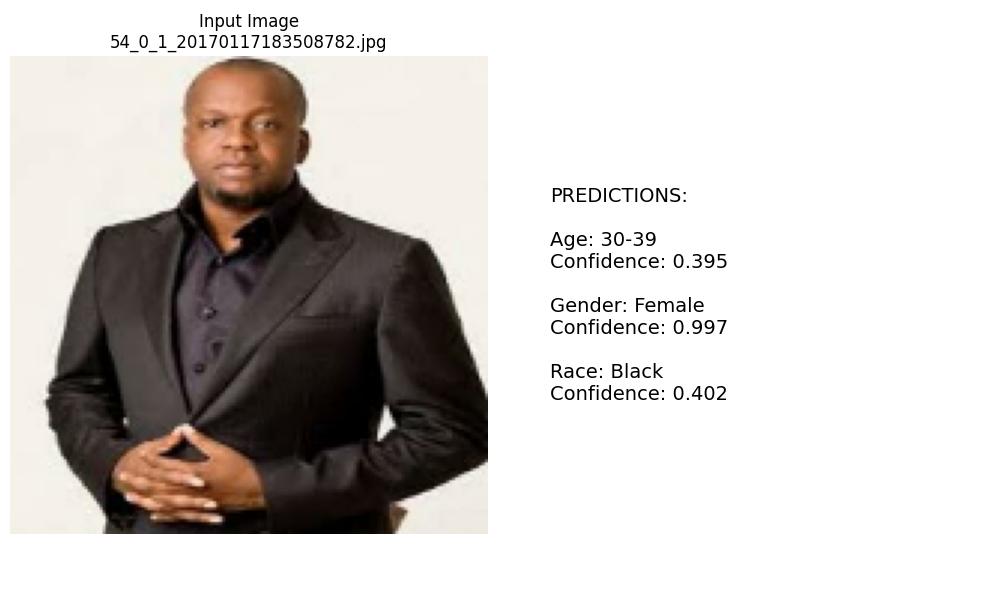

{'age': '30-39',
 'gender': 'Female',
 'race': 'Black',
 'age_confidence': 0.3949109613895416,
 'gender_confidence': 0.9967926740646362,
 'race_confidence': 0.40164807438850403,
 'raw_predictions': {'age_output': array([[4.6370960e-06, 1.7474538e-02, 3.4088403e-01, 4.5445145e-04,
          3.9491096e-01, 1.6230297e-01, 5.5098452e-02, 2.3914618e-02,
          4.9553928e-03]], dtype=float32),
  'gender_output': array([[0.9967927]], dtype=float32),
  'race_output': array([[0.40164807, 0.01163881, 0.29884312, 0.10592048, 0.13733312,
          0.01621396, 0.02840248]], dtype=float32)}}

In [ ]:
test_single_image(image_path)

In [ ]:
test_with_gradcam(image_path, task='age')

Could not find suitable layer for Grad-CAM


Prediction: 30-39 (confidence: 0.395)
All class probabilities:
- 0-2: 0.000
- 10-19: 0.017
- 20-29: 0.341
- 3-9: 0.000
- 30-39: 0.395
- 40-49: 0.162
- 50-59: 0.055
- 60-69: 0.024
- 70+: 0.005

Running LIME explanation with 1000 samples...


100%|██████████| 1000/1000 [00:42<00:00, 23.68it/s]


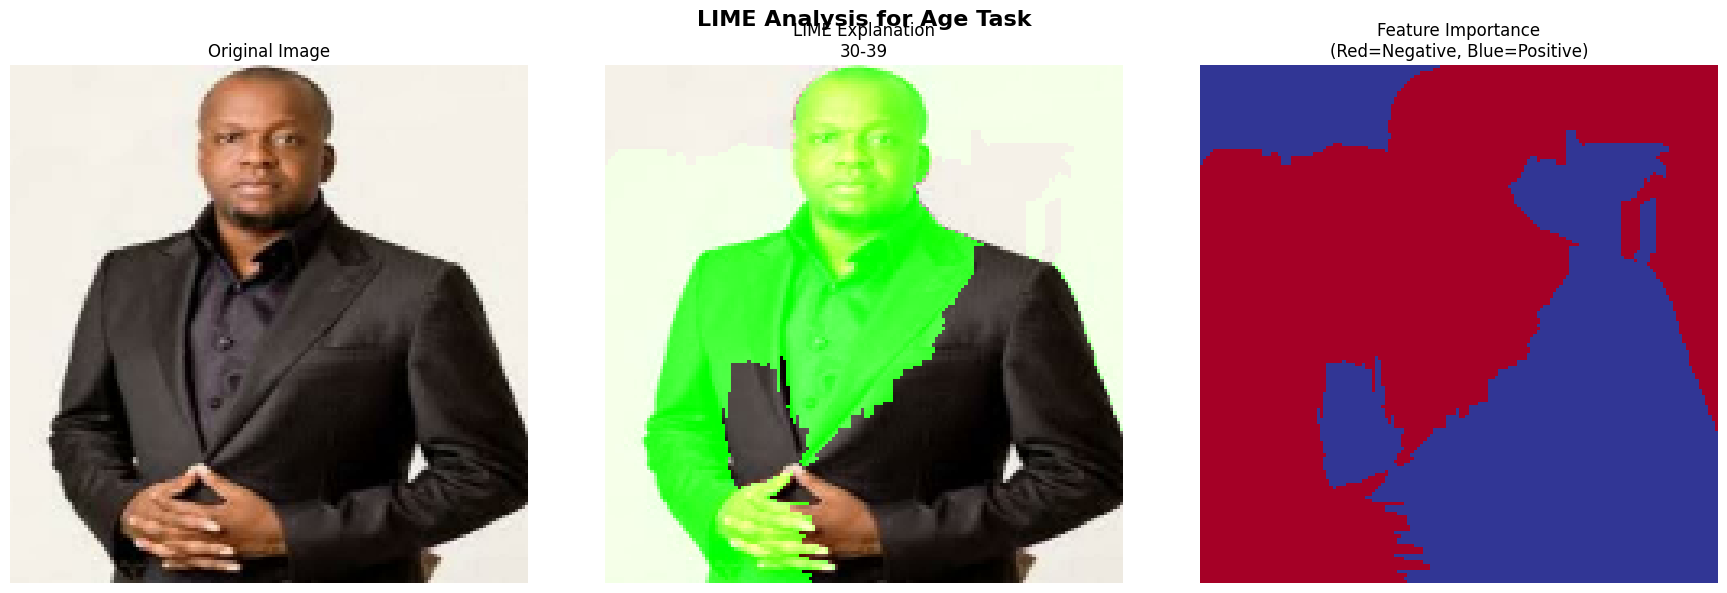


Top 10 superpixel contributions for '30-39' task:
1. Superpixel 10: 0.050 (positive)
2. Superpixel 3: 0.046 (positive)
3. Superpixel 8: 0.038 (positive)
4. Superpixel 4: 0.037 (positive)
5. Superpixel 2: 0.020 (positive)
6. Superpixel 14: 0.019 (positive)
7. Superpixel 17: 0.016 (positive)
8. Superpixel 6: 0.014 (positive)
9. Superpixel 7: 0.012 (positive)
10. Superpixel 16: 0.010 (positive)


(<lime.lime_image.ImageExplanation at 0x17d1f72c190>,
 {'predicted_class': np.int64(4),
  'predicted_label': '30-39',
  'confidence': np.float32(0.39491096),
  'all_probabilities': array([4.6370960e-06, 1.7474538e-02, 3.4088403e-01, 4.5445145e-04,
         3.9491096e-01, 1.6230297e-01, 5.5098452e-02, 2.3914618e-02,
         4.9553928e-03], dtype=float32),
  'class_names': array(['0-2', '10-19', '20-29', '3-9', '30-39', '40-49', '50-59', '60-69',
         '70+'], dtype=object)},
 array([[[245, 241, 232],
         [245, 241, 232],
         [245, 241, 232],
         ...,
         [245, 241, 232],
         [245, 241, 232],
         [245, 241, 232]],
 
        [[245, 241, 232],
         [245, 241, 232],
         [245, 241, 232],
         ...,
         [245, 241, 232],
         [245, 241, 232],
         [245, 241, 232]],
 
        [[245, 241, 232],
         [245, 241, 232],
         [245, 241, 232],
         ...,
         [245, 241, 232],
         [245, 241, 232],
         [245, 241, 232]],


In [ ]:
test_with_lime(image_path, task='age')